In [9]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import pickle
from itertools import islice, cycle
from tqdm import tqdm

from graspy.embed import JointRDPG
from graspy.plot import heatmap
from graspy.utils import is_symmetric, symmetrize
from graspy.cluster import GaussianCluster, KMeansCluster

from mgcpy.independence_tests.dcorr import DCorr
from mgcpy.independence_tests.rv_corr import RVCorr
from mgcpy.independence_tests.mgc.mgc import MGC

from simulations import rho_sbm_marg, rho_ER_marg, sbm_marg_corr_diff
from utils import sbm_params, block_permute, triu_no_diag, to_distance_mtx, identity, estimate_block_assignment, sort_graph

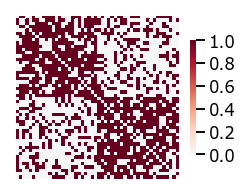

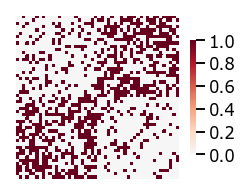

In [2]:
n = 50
k = 2
A, B = rho_sbm_marg(rho=0.3, k=2, AL=sbm_params(a=0.7, b=0.3), BL=sbm_params(a=0.2, b=0.5), n=n)
heatmap(A, figsize=(4,3))
heatmap(B, figsize=(4,3))

In [3]:
true_assignments = np.repeat(np.arange(0, k), repeats=n//k)
colors = np.array(['#377eb8', '#ff7f00', '#4daf4a',
                    '#f781bf', '#a65628', '#984ea3',])

In [4]:
jrdpg = JointRDPG()
jrdpg.fit([A, B])
Vhat = jrdpg.latent_left_

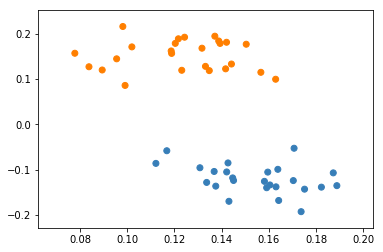

In [5]:
plt.scatter(x=Vhat[:,0], y=Vhat[:, 1], color=colors[true_assignments])

In [6]:
gmm = GaussianCluster(max_components=2)
est_assignment = gmm.fit_predict(Vhat)

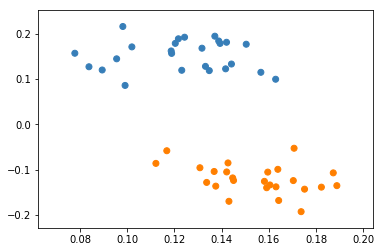

In [7]:
plt.scatter(x=Vhat[:,0], y=Vhat[:, 1], color=colors[est_assignment])

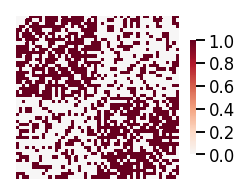

In [35]:
heatmap(A, figsize=(4, 3))

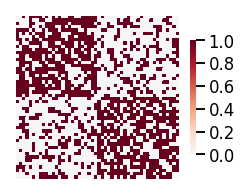

In [36]:
heatmap(block_permute(A, est_assignment), figsize=(4, 3))

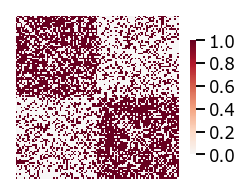

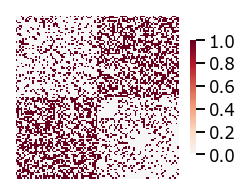

In [6]:
A, B = rho_sbm_marg(rho=0.1, k=2, AL=sbm_params(a=0.7, b=0.3), BL=sbm_params(a=0.2, b=0.5), n=100)
heatmap(A, figsize=(4,3))
heatmap(B, figsize=(4,3))

In [7]:
estimate_block_assignment(A, B)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [10]:
def rho_sbm_power(indept_test, transform_func, rho, P1, P2, k, n, mc=500, alpha=0.05):
    test_stat_null_array = np.zeros(mc)
    test_stat_alt_array = np.zeros(mc)
    for i in tqdm(range(mc)):
        A, B = rho_sbm_marg(rho, k, P1, P2, n)
        test_stat_alt, _ = indept_test.test_statistic(
            matrix_X=transform_func(A), matrix_Y=transform_func(B))
        test_stat_alt_array[i] = test_stat_alt

        # generate the null by permutation
        block_assignment = estimate_block_assignment(A, B)
        B_sorted = sort_graph(B, block_assignment)
        A_null = block_permute(A, block_assignment)
        test_stat_null, _ = indept_test.test_statistic(
            matrix_X=transform_func(A_null), matrix_Y=transform_func(B_sorted))
        test_stat_null_array[i] = test_stat_null
    # if pearson, use the absolute value of test statistic then use one-sided
    # rejection region
    if indept_test.get_name() == 'pearson':
        test_stat_null_array = np.absolute(test_stat_null_array)
        test_stat_alt_array = np.absolute(test_stat_alt_array)
    critical_value = np.sort(test_stat_null_array)[math.ceil((1-alpha)*mc)]
    power = np.where(test_stat_alt_array > critical_value)[0].shape[0] / mc
    return power

In [11]:
%%time
n_arr = np.linspace(10, 100, 10, dtype=int)
rho_arr = np.array([0, 0.1])
nmc = 1000
P1 = sbm_params(a=0.7, b=0.3)
P2 = sbm_params(a=0.2, b=0.5)
test_names = ['pearson', 'dcorr', 'mgc']
power_sbm = {
    'pearson': np.zeros((rho_arr.shape[0], n_arr.shape[0])),
    'dcorr': np.zeros((rho_arr.shape[0], n_arr.shape[0])),
    'mgc': np.zeros((rho_arr.shape[0], n_arr.shape[0]))
}

for name in test_names:
    for i, rho in enumerate(rho_arr):
        for j, n in enumerate(n_arr):
            if name == 'pearson':
                test = RVCorr(which_test='pearson')
                test_power = rho_sbm_power(test, triu_no_diag, mc=nmc,
                                           rho=rho, P1=P1, P2=P2, k=2, n=n)
            elif name == 'dcorr':
                test = DCorr(compute_distance_matrix=identity)
                test_power = rho_sbm_power(test, to_distance_mtx, mc=nmc,
                                           rho=rho, P1=P1, P2=P2, k=2, n=n)
            elif name == 'mgc':
                test = MGC(compute_distance_matrix=identity)
                test_power = rho_sbm_power(test, to_distance_mtx, mc=nmc,
                                           rho=rho, P1=P1, P2=P2, k=2, n=n)
            power_sbm[name][i, j] = test_power
            print('finish {} for rho={}, n={}'.format(name, rho, n))

 32%|███▏      | 320/1000 [00:20<00:47, 14.20it/s]/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return_n_iter=True)
  0%|          | 2/1000 [00:00<01:05, 15.22it/s]

finish pearson for rho=0.0, n=10


  0%|          | 1/1000 [00:00<01:57,  8.48it/s]

finish pearson for rho=0.0, n=20


  0%|          | 2/1000 [00:00<01:39, 10.04it/s]

finish pearson for rho=0.0, n=30


  0%|          | 1/1000 [00:00<01:54,  8.73it/s]

finish pearson for rho=0.0, n=40


  0%|          | 2/1000 [00:00<01:30, 11.05it/s]

finish pearson for rho=0.0, n=50


  0%|          | 1/1000 [00:00<01:45,  9.51it/s]

finish pearson for rho=0.0, n=60


  0%|          | 1/1000 [00:00<02:22,  7.01it/s]

finish pearson for rho=0.0, n=70


  0%|          | 1/1000 [00:00<02:10,  7.65it/s]

finish pearson for rho=0.0, n=80


  0%|          | 1/1000 [00:00<02:33,  6.53it/s]

finish pearson for rho=0.0, n=90


  0%|          | 2/1000 [00:00<00:55, 18.14it/s]

finish pearson for rho=0.0, n=100


  0%|          | 2/1000 [00:00<01:01, 16.31it/s]

finish pearson for rho=0.1, n=10


  0%|          | 2/1000 [00:00<01:39,  9.98it/s]

finish pearson for rho=0.1, n=20


  0%|          | 0/1000 [00:00<?, ?it/s]

finish pearson for rho=0.1, n=30


  0%|          | 0/1000 [00:00<?, ?it/s]

finish pearson for rho=0.1, n=40


  0%|          | 1/1000 [00:00<01:55,  8.63it/s]

finish pearson for rho=0.1, n=50


  0%|          | 0/1000 [00:00<?, ?it/s]

finish pearson for rho=0.1, n=60


  0%|          | 1/1000 [00:00<01:49,  9.12it/s]

finish pearson for rho=0.1, n=70


  0%|          | 1/1000 [00:00<01:56,  8.59it/s]

finish pearson for rho=0.1, n=80


  0%|          | 1/1000 [00:00<02:19,  7.16it/s]

finish pearson for rho=0.1, n=90


  0%|          | 2/1000 [00:00<00:55, 18.08it/s]

finish pearson for rho=0.1, n=100


 62%|██████▏   | 624/1000 [00:34<00:21, 17.76it/s]/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return_n_iter=True)
  0%|          | 2/1000 [00:00<01:04, 15.43it/s]

finish dcorr for rho=0.0, n=10


  0%|          | 2/1000 [00:00<01:09, 14.28it/s]

finish dcorr for rho=0.0, n=20


  0%|          | 2/1000 [00:00<01:22, 12.14it/s]

finish dcorr for rho=0.0, n=30


  0%|          | 1/1000 [00:00<02:10,  7.63it/s]

finish dcorr for rho=0.0, n=40


  0%|          | 1/1000 [00:00<02:18,  7.20it/s]

finish dcorr for rho=0.0, n=50


  0%|          | 1/1000 [00:00<03:08,  5.29it/s]

finish dcorr for rho=0.0, n=60


  0%|          | 1/1000 [00:00<01:48,  9.17it/s]

finish dcorr for rho=0.0, n=70


  0%|          | 1/1000 [00:00<02:04,  7.99it/s]

finish dcorr for rho=0.0, n=80


  0%|          | 1/1000 [00:00<01:42,  9.73it/s]

finish dcorr for rho=0.0, n=90


  0%|          | 2/1000 [00:00<00:56, 17.66it/s]

finish dcorr for rho=0.0, n=100


  0%|          | 2/1000 [00:00<01:03, 15.75it/s]

finish dcorr for rho=0.1, n=10


  0%|          | 2/1000 [00:00<01:09, 14.32it/s]

finish dcorr for rho=0.1, n=20


  0%|          | 2/1000 [00:00<01:25, 11.72it/s]

finish dcorr for rho=0.1, n=30


  0%|          | 1/1000 [00:00<01:45,  9.48it/s]

finish dcorr for rho=0.1, n=40


  0%|          | 1/1000 [00:00<01:54,  8.71it/s]

finish dcorr for rho=0.1, n=50


  0%|          | 1/1000 [00:00<02:08,  7.79it/s]

finish dcorr for rho=0.1, n=60


  0%|          | 1/1000 [00:00<02:30,  6.63it/s]

finish dcorr for rho=0.1, n=70


  0%|          | 1/1000 [00:00<01:54,  8.71it/s]

finish dcorr for rho=0.1, n=80


  0%|          | 1/1000 [00:00<01:53,  8.81it/s]

finish dcorr for rho=0.1, n=90


  0%|          | 2/1000 [00:00<00:56, 17.54it/s]

finish dcorr for rho=0.1, n=100


  4%|▍         | 40/1000 [00:02<00:55, 17.34it/s]/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1704: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:874: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:874: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)
 46%|████▌     | 458/1000 [00:26<00:31, 17.22it/s]/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (9). Po

finish mgc for rho=0.0, n=10


  0%|          | 2/1000 [00:00<01:21, 12.25it/s]

finish mgc for rho=0.0, n=20


  0%|          | 1/1000 [00:00<01:52,  8.89it/s]

finish mgc for rho=0.0, n=30


  0%|          | 1/1000 [00:00<02:05,  7.98it/s]

finish mgc for rho=0.0, n=40


  0%|          | 1/1000 [00:00<02:04,  8.05it/s]

finish mgc for rho=0.0, n=50


  0%|          | 1/1000 [00:00<02:12,  7.55it/s]

finish mgc for rho=0.0, n=60


  0%|          | 1/1000 [00:00<02:18,  7.22it/s]

finish mgc for rho=0.0, n=70


  0%|          | 1/1000 [00:00<02:33,  6.50it/s]

finish mgc for rho=0.0, n=80


  0%|          | 0/1000 [00:00<?, ?it/s]

finish mgc for rho=0.0, n=90


  0%|          | 2/1000 [00:00<00:56, 17.66it/s]

finish mgc for rho=0.0, n=100


 13%|█▎        | 126/1000 [00:07<00:51, 16.96it/s]/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1704: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:874: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:874: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)
 13%|█▎        | 130/1000 [00:07<00:52, 16.51it/s]/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1704: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x -

finish mgc for rho=0.1, n=10


  0%|          | 2/1000 [00:00<01:28, 11.28it/s]

finish mgc for rho=0.1, n=20


  0%|          | 1/1000 [00:00<02:03,  8.11it/s]

finish mgc for rho=0.1, n=30


  0%|          | 1/1000 [00:00<02:18,  7.20it/s]

finish mgc for rho=0.1, n=40


  0%|          | 1/1000 [00:00<03:03,  5.44it/s]

finish mgc for rho=0.1, n=50


  0%|          | 1/1000 [00:00<02:15,  7.38it/s]

finish mgc for rho=0.1, n=60


  0%|          | 1/1000 [00:00<02:29,  6.68it/s]

finish mgc for rho=0.1, n=70


  0%|          | 1/1000 [00:00<03:03,  5.45it/s]

finish mgc for rho=0.1, n=80


  0%|          | 1/1000 [00:00<03:14,  5.13it/s]

finish mgc for rho=0.1, n=90


100%|██████████| 1000/1000 [03:10<00:00,  5.39it/s]

finish mgc for rho=0.1, n=100
CPU times: user 3h 7min 34s, sys: 12min 49s, total: 3h 20min 24s
Wall time: 1h 54min 41s


In [12]:
power_sbm

{'pearson': array([[0.068, 0.073, 0.045, 0.04 , 0.04 , 0.051, 0.039, 0.045, 0.052,
         0.051],
        [0.04 , 0.003, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
         0.   ]]),
 'dcorr': array([[0.031, 0.002, 0.001, 0.043, 0.046, 0.066, 0.066, 0.047, 0.046,
         0.055],
        [0.033, 0.032, 0.081, 0.756, 0.911, 0.976, 0.991, 0.999, 1.   ,
         1.   ]]),
 'mgc': array([[0.028, 0.001, 0.   , 0.039, 0.038, 0.044, 0.047, 0.042, 0.055,
         0.049],
        [0.03 , 0.035, 0.065, 0.733, 0.923, 0.975, 0.993, 0.999, 1.   ,
         1.   ]])}

In [14]:
with open('../results/rho_sbm_marg_est_block_power.pkl', 'wb') as f:
    pickle.dump(power_sbm, f)

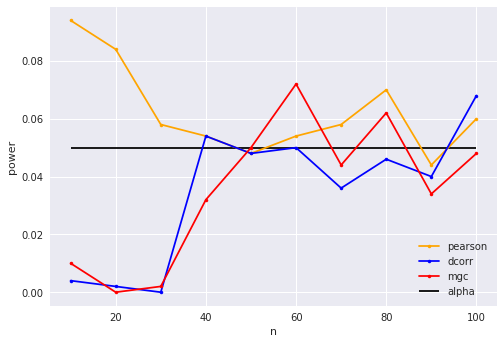

In [49]:
rho = 0
for name, test_power in power_results.items():
        plt.plot(n_arr, test_power[0, :], color=colors[name], linestyle='-', marker='.', label='{}'.format(name))

plt.hlines(y=0.05, xmin=np.amin(n_arr), xmax=np.amax(n_arr), label='alpha')
plt.legend(loc=4)
plt.xlabel('n')
plt.ylabel('power')
plt.savefig('../figures/sbm_marg_est_block_power_null.png', bbox_inches='tight')

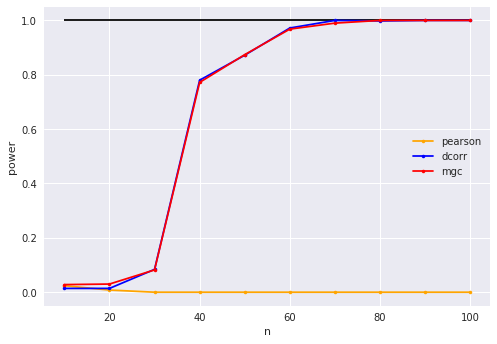

In [50]:
rho = 0.1
for name, test_power in power_results.items():
        plt.plot(n_arr, test_power[1, :], color=colors[name], linestyle='-', marker='.', label='{}'.format(name))

plt.hlines(y=1, xmin=np.amin(n_arr), xmax=np.amax(n_arr))
plt.legend(loc=7)
plt.xlabel('n')
plt.ylabel('power')
plt.savefig('../figures/sbm_marg_est_block_power_alt.png'.format(rho), bbox_inches='tight')